In [1]:
import components
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
path_results = "results/"

### simulation

#### initialize helper objects for simulation
- SimulationBroker
- VehicleGenerator
- ResultWriter

In [2]:
# simulation broker
path_Sim = "test_data/beam1/beam1-0.csv"
dtype_Sim = {
       'time': 'int64', 'type': 'category', 'vehicle': 'int64', 'parkingTaz': 'category','chargingPointType': 'category', 
       'primaryFuelLevel': 'float64', 'mode': 'category', 'currentTourMode': 'category', 'vehicleType': 'category', 
       'arrivalTime': 'float64', 'departureTime': 'float64', 'linkTravelTime': 'string', 'primaryFuelType': 'category', 
       'parkingZoneId': 'category','duration': 'float64' 
        }
SimBroker = components.SimBroker(path_Sim, dtype_Sim)

# vehicle generator
path_DataBase = "test_data/vehicleFiles/vehicletypes-Base_2035_20210204_updated.csv"
VehicleGenerator = components.VehicleGenerator(path_Sim, dtype_Sim, path_DataBase)

path_save = path_results+"sim1"
ResultWriter = components.ResultWriter(path_save)

In [3]:
# show head of vehicles dataframe
VehicleGenerator.vehicles.head(3)

,vehicleType
vehicle,
2517,ev-L1-0-to-50000-LowTech-2035-Midsize-BEV_300_XFC
9368,ev-L1-0-to-50000-LowTech-2035-Midsize-BEV_300_XFC
11104,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC


#### create charging stations
1) map parkingZoneIds to charging stations with a dictionary
2) create charging Stations

In [4]:
# load infrastructure file into dataframe
path_infrastructure = "test_data/beam1/gemini-base-scenario-3-charging-no-household-infra16.csv"
usecols_infrastructure = ["taz", "parkingType", "chargingPointType", "parkingZoneId"]
dtype_infrastructure = {"taz": "int64", "parkingType": "category", "chargingPointType": "category", "parkingZoneId": "string"}
infrastructure = pd.read_csv(path_infrastructure, dtype=dtype_infrastructure, usecols=usecols_infrastructure)
infrastructure = infrastructure.set_index("parkingZoneId")
# filter infrastructure for only public fast and extreme fast charging
infrastructure = infrastructure.loc[infrastructure["parkingType"] == "Public"]
infrastructure = infrastructure.loc[infrastructure["chargingPointType"].str.contains("publicfc|publicxfc")]
infrastructure = infrastructure.sort_values(by = ["taz", "parkingZoneId"])

#now, make a dict of every parkingZoneId that belongs to a charging station
# here, we will split the chargingstation
chargingStationMappedToParkingZoneId = {}
chargingStationMappedToTaz = {}
stepsize = 200
i = 0 
j = 1
stop = False
while i < len(infrastructure) -1 :
    name = "chargingStation-" + str(j)
    # we want to make sure, that all the chargingBays of one TAZ are in one chargingStation
    if i + stepsize < len(infrastructure) :
        i_end = i+stepsize
        while infrastructure.iloc[i_end]["taz"] == infrastructure.iloc[i_end+1]["taz"]:
            i_end +=1 # if the taz is the same, we should increase reading to that taz
            if i_end +1 >= len(infrastructure) - 1 : # make sure, that we don't try to read in the next step something that doesnt exist
                stop = True
                break
    else: 
        i_end = len(infrastructure)-1
    if not stop:
        i_end += 1 # to also catch the last element
    slice = infrastructure.iloc[i:i_end]
    chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
    chargingStationMappedToTaz[name] = list(set(slice["taz"].to_list())) # this removes duplicates
    i = i_end # start reading next cycle at i
    j += 1

# we convert chargingStationMappedToTaz to a dataframe to use search methods
chargingStationMappedToTaz = pd.DataFrame.from_dict(chargingStationMappedToTaz, orient='index')
chargingStationMappedToTaz = chargingStationMappedToTaz.transpose()

# #here, we will make chargingStation depending on TAZ. Therefore, get a list of the different TAZ and sort it:
# taz = infrastructure.taz.drop_duplicates().to_list()
# taz = sorted(taz)
# while i < len(taz):
#     name = "chargingStation-" + str(j)
#     # slice = infrastructure.loc[infrastructure["taz"].isin(taz[i:i+stepsize])]
#     chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
#     i += stepsize
#     j += 1

In [5]:
infrastructure.head(3)

,taz,parkingType,chargingPointType
parkingZoneId,,,
X-PEV-9-1,9,Public,publicfc(150.0|DC)
X-PEV-11-1,11,Public,publicfc(150.0|DC)
X-PEV-12-1,12,Public,publicfc(150.0|DC)


In [6]:
chargingStationMappedToTaz

,chargingStation-1,chargingStation-2,chargingStation-3
0,518.0,947.0,1280.0
1,520.0,948.0,1412.0
2,9.0,949.0,1273.0
3,11.0,950.0,1146.0
4,12.0,951.0,1161.0
...,...,...,...
112,478.0,NaN,NaN
113,485.0,NaN,NaN
114,486.0,NaN,NaN
115,497.0,NaN,NaN


In [7]:
#create chargingStations
chargingStations = [] # list of charging stations
for i in chargingStationMappedToParkingZoneId:
    #chargingStations.append(i)

    ChargingStationId = i
    # make a list with the powers of the bays:
    ChBaMaxPower = []
    for j in chargingStationMappedToParkingZoneId[i]:
        power_string = infrastructure.loc[j, "chargingPointType"]
        ChBaMaxPower.append(components.chargingCapFromString(power_string))
    # for now, we assume that all charging bays have the same charging power
    PowerMax = max(ChBaMaxPower)
    len_power = len(ChBaMaxPower)
    ChBaMaxPower = []
    # make charging limit for each bay the same
    for j in range(0, len_power):
        ChBaMaxPower.append(PowerMax)
    del PowerMax, len_power
    
    ChBaParkingZoneId = chargingStationMappedToParkingZoneId[i]
    calcBtmsGridProp = True
    
    '''reduce number of charging bays to test controller'''
    numStations = 30
    ChBaMaxPower = ChBaMaxPower[0:numStations]
    ChBaNum = len(ChBaMaxPower)
    
    ## specify here charging station
    container = components.ChaDepMpcBase(ChargingStationId=ChargingStationId, ResultWriter=ResultWriter, SimBroker = SimBroker, ChBaMaxPower=ChBaMaxPower, ChBaParkingZoneId=ChBaParkingZoneId, ChBaNum = ChBaNum ,calcBtmsGridProp = True)
    chargingStations.append(container)
    print(ChargingStationId + " was created with " + str(container.ChBaNum) + " charging bays and " + str(container.BtmsSize) + "kWh BTM-Storage")

'''write charging station properties to ResultWriter'''
ResultWriter.saveChargingStationProperties(chargingStations)

30
chargingStation-1 was created with 30 charging bays and 3750.0kWh BTM-Storage
30
chargingStation-2 was created with 30 charging bays and 3750.0kWh BTM-Storage
30
chargingStation-3 was created with 30 charging bays and 3750.0kWh BTM-Storage


In [8]:
print(len(ChBaMaxPower))
print(ChBaNum)

30
30


- initialize helper objects for simulation input

In [9]:
PhySimDummy = components.PhySimDummy(chargingStations)
DermsDummy  = components.DermsDummy(chargingStations)

#### initialize simulation
initialize Grid Constraints and actual time of charging Station

In [10]:
'''Simulation settings:'''
timestep = 5 * 60

In [11]:
for x in chargingStations:
    GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
    x.initialize(GridPowerLower = GridPowerLower, GridPowerUpper = GridPowerUpper)

generate predictions for power use of charging station

In [12]:
if type(chargingStations[0]) == components.ChaDepMpcBase:
    for x in chargingStations:
        x.generatePredictions(path_BeamPredictionFile = path_Sim, dtype = dtype_Sim, path_DataBase = path_DataBase, timestep = timestep, addNoise = True)

plot prediction 

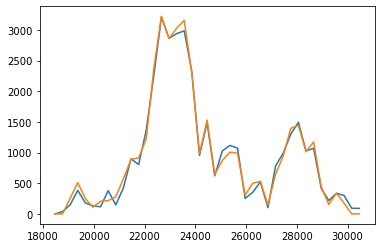

In [13]:
x = chargingStations[2]
time = x.PredictionTime
power = x.PredictionPower

ax = plt.subplot()
ax.plot(time,power)
ax.plot(time,x.power_sum_original)

BTMS size optimization

see mpcBase.md for explanations


 chargingStation-1
Optimization with free power level of 2692 kW
The determined effective BTMS size is 1226 kWh.
The associated C-Rating is 1.5942785177059455
The cost-value is $ 86 from which $ 0 is associated with demand charge, $ 63 is associated with BTMS degradation and $ 23 is associated with energy losses
The total delivered energy to the vehicles is 7666 kWh, which results in an average power of 2243 kW
1436 kWh were delivered by the BTMS and charging losses of 155 kWh occured.
The maximal grid power is 2692 kW

 chargingStation-2
Optimization with free power level of 1326 kW
The determined effective BTMS size is 1779 kWh.
The associated C-Rating is 1.9105021928049462
The cost-value is $ 105 from which $ 0 is associated with demand charge, $ 77 is associated with BTMS degradation and $ 28 is associated with energy losses
The total delivered energy to the vehicles is 3775 kWh, which results in an average power of 1105 kW
1738 kWh were delivered by the BTMS and charging losses o

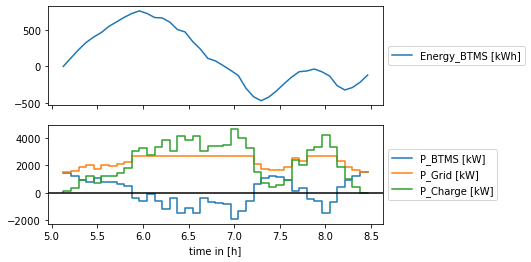

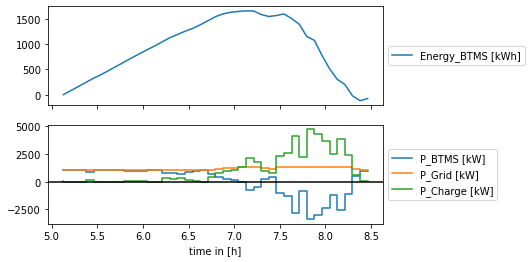

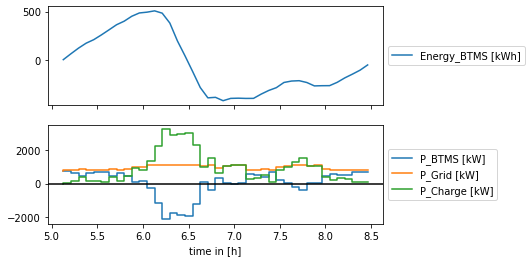

In [14]:
a               = 20/30 #* ((SimBroker.t_max - SimBroker.t_act)/3.6e3)/24       # demand charge per day
P_free_Ratio    =  1.2      # free power, after which demand charge is applied, as ratio to avg power
b               = 200/5000    # btms cost per cycle
c               = 0.15      # electricity cost per kWh

Print = True
Graph = True
for i in range(0, len(chargingStations)):
    x = chargingStations[i]
    #determine P_free
    avgPower = sum(x.PredictionPower*timestep)/(max(x.PredictionTime) + timestep - min(x.PredictionTime))
    P_free = P_free_Ratio *avgPower
    time, btms_size, P_Grid, P_BTMS, P_BTMS_Ch, P_BTMS_DCh, E_BTMS, P_Charge, cost = x.determineBtmsSize(SimBroker.t_act, SimBroker.t_max, timestep, a, b, c, P_free)
    time = time/3.6e3 #conversion to hours
    if Print:
        print('\n', x.ChargingStationId)
        print('Optimization with free power level of', int(P_free), 'kW')
        print('The determined effective BTMS size is', int(btms_size), 'kWh.')
        cRating = max(abs(P_BTMS))/btms_size
        print('The associated C-Rating is', cRating)
        costLoss = c*(sum(P_BTMS_Ch*timestep/3.6e3) + sum(P_BTMS_DCh*timestep/3.6e3)) # btmsDCh is always negative
        costCycle = b*sum(P_BTMS_Ch*timestep/3.6e3)
        print('The cost-value is $', int(cost), 'from which $', int(a*(max(P_Grid)-P_free)), 'is associated with demand charge, $', int(costCycle), 'is associated with BTMS degradation and $', int(costLoss), 'is associated with energy losses')
        E_total = sum(timestep/3.6e3*P_Charge)
        print('The total delivered energy to the vehicles is', int(E_total), 'kWh, which results in an average power of' , int(E_total/(max(time)-min(time) + timestep/3.6e3)), 'kW')
        print(int(-sum(P_BTMS_DCh*timestep/3.6e3)), 'kWh were delivered by the BTMS and charging losses of', int(sum(P_BTMS_DCh*timestep/3.6e3) + sum(P_BTMS_Ch*timestep/3.6e3)), 'kWh occured.')
        print('The maximal grid power is', int(max(P_Grid)), 'kW')

    if Graph:
        fig, ax = plt.subplots(2,1, sharex = True)

        ax[0].plot(time, E_BTMS, label = "Energy_BTMS [kWh]")
        ax[0].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))

        ax[1].step(time, P_BTMS, label = "P_BTMS [kW]")
        ax[1].step(time, P_Grid, label = "P_Grid [kW]")
        ax[1].step(time, P_Charge, label = "P_Charge [kW]")
        ax[1].axhline(0, color = 'black')
        ax[1].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
        ax[1].set_xlabel("time in [h]")

further reduce btms size with a factor

In [15]:
factor = 1.0
for x in chargingStations:
    x.BtmsSize = factor * x.determinedBtmsSize
    x.BtmsMaxPower= factor * x.determinedMaxPower

creat optimal day-ahead plan

In [16]:
d = 10
P_avg = 200
for x in chargingStations:
    x.planning(SimBroker.t_act, SimBroker.t_max, timestep, a, b, c, d, P_free, P_avg)
# TODO make function call nicer and choose parameter correctly

#### run simulation

In [11]:
SimBroker.reset()
ResultWriter.reset()
# charging station is not resetted

iteration = 0

while not SimBroker.eol():

    # Sim Broker Step
    slice = SimBroker.step(timestep)

    #update values from DERMS and PhysicalSimulation
    for x in chargingStations:
        # update SiteNet Power Limits from Derms
        GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
        x.updateFromDerms(GridPowerLower, GridPowerUpper)
        # update CES SOC from PhysicalSimulation
        x.updateFromPhySim(PhySimDummy.output(x.ChargingStationId))

    # generate Vehicles if charging Plug in event
    for i in range(0, len(slice)):
        if slice.iloc[i]["type"] == "ChargingPlugInEvent":
            # generate vehicle
            vehicle = VehicleGenerator.generateVehicleSO(slice.iloc[i])
            # let vehicle arrive at a charging station - here depending on taz
            taz = int(slice.iloc[i]["parkingTaz"]) # this is a str
            #find out which chargingStation belongs to the taz
            res = chargingStationMappedToTaz.isin([taz]).any().values
            index = np.where(res == True)[0][0]

            #let vehicles arrive at designated chargingStation
            chargingStations[index].arrival(vehicle, SimBroker.t_act)

    #control action and simulation
    
    # call step function
    for x in chargingStations:
        x.step(timestep)

    # provide outputs
    for x in chargingStations:
        PhySimDummy.input(x.ChargingStationId, sum(x.ChBaPower), x.BtmsPower, timestep)
        DermsDummy.input(x.ChargingStationId, x.PowerDesire)

    '''for testing'''
    if iteration>60:
         break
    iteration +=1
    #if SimBroker.t_act >= 26000:
    #    break
print("number of iterations:" +str(iteration))
    

c:\Users\akaju\Documents\GitHub\xfc-btms-saev-controller\components\Vehicle.py:49: RuntimeWarning: invalid value encountered in double_scalars
  E_reference = self.VehicleEngy_Arrival + (self.VehicleDesEngy-self.VehicleEngy_Arrival)/(self.VehicleDesEnd - self.VehicleArrival) * (t_act - self.VehicleArrival)


number of iterations:41


In [28]:
# for i in range(0,3):
#    print(chargingStations[i].ChBaVehicles)
#print(chargingStations[0].ChBaVehicles)
print(iteration)
print(chargingStations[2].chBaActiveCharges())
print(chargingStations[2].ChBaNum)
print(len(chargingStations[0].ChBaVehicles))
#print(chargingStations[0].Queue[0])
#chargingStations[0].ChBaParkingZoneId

41
1
30
30


True

#### sneak peak into results

In [13]:
VehicleEvents = ResultWriter.Events.loc[ResultWriter.Events.VehicleId == 2921283]
VehicleEvents.head(3)

,time,Event,ChargingStationId,VehicleId,QueueOrBay,ChargingDesire,VehicleType,VehicleArrival,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,VehicleMaxEnergy,VehicleMaxPower,ChargingBayMaxPower
44,19663,ArrivalEvent,chargingStation-1,2921283,,inf,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300,19540,19540,70.027023,70.027023,0.834113,83.953903,150.0,NaN
50,19663,ReparkEvent,chargingStation-1,2921283,Bay,inf,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300,19540,19540,70.027023,70.027023,0.834113,83.953903,150.0,250.0
58,19663,ReleaseEvent,chargingStation-1,2921283,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300,19540,19540,70.027023,70.027023,0.834113,83.953903,150.0,NaN


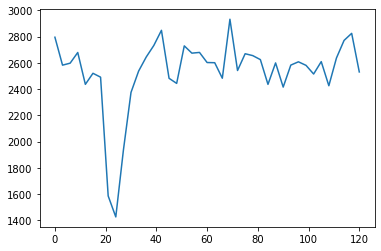

In [14]:
df = ResultWriter.ChargingStationStates
df1 = df.loc[df.ChargingStationID == "chargingStation-1"]
#df1
fig = plt.plot(df1.BtmsPower + df1.TotalChargingPower)

In [15]:
df3 = ResultWriter.ChargingStationStates
df3.head(5)

,time,ChargingStationID,BaysVehicleIds,BaysChargingPower,TotalChargingPower,BaysChargingDesire,BaysNumberOfVehicles,QueueVehicleIds,QueueChargingDesire,QueueNumberOfVehicles,BtmsPower,BtmsSoc,BtmsEnergy,TotalChargingPowerDesire,GridPowerUpper,GridPowerLower,PowerDesire,BtmsPowerDesire,EnergyLagSum,TimeLagSum
0,18463,chargingStation-1,"[5270466, 3256681, 1545605]","[0, 0, 174.49999999999997, 0, 0, 0, 0, 0, 0, 0...",174.5,"[inf, inf, 0.4034682080924855, nan, nan, nan, ...",3,[],[],0,2621.250911,0.558250,2093.437576,0,2795.750911,-2795.750911,0,3750.0,9.125,-219
1,18463,chargingStation-2,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,2590.806034,0.557573,2090.900503,0,2590.806034,-2590.806034,0,3750.0,0.000,0
2,18463,chargingStation-3,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,2789.985208,0.562000,2107.498767,0,2789.985208,-2789.985208,0,3750.0,0.000,0
3,18763,chargingStation-1,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,2582.701127,0.615643,2308.662670,0,2582.701127,-2582.701127,0,3750.0,0.000,0
4,18763,chargingStation-2,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,2836.545418,0.620608,2327.279288,0,2836.545418,-2836.545418,0,3750.0,0.000,0


In [16]:
df2=ResultWriter.Events
df2 = df2.loc[df2.ChargingStationId =='chargingStation-1']
df2.head(3)

,time,Event,ChargingStationId,VehicleId,QueueOrBay,ChargingDesire,VehicleType,VehicleArrival,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,VehicleMaxEnergy,VehicleMaxPower,ChargingBayMaxPower
0,18463,ArrivalEvent,chargingStation-1,5270466,,inf,ev-L1-0-to-50000-LowTech-2035-SUV-BEV_300_XFC,18163,18163,70.439238,70.439238,0.839023,83.953903,400.0,NaN
1,18463,ArrivalEvent,chargingStation-1,3256681,,inf,ev-L1-0-to-50000-LowTech-2035-Car-BEV_200,18406,18406,46.803395,46.803395,0.836234,55.969269,150.0,NaN
2,18463,ArrivalEvent,chargingStation-1,1545605,,0.403468,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC,18633,18982,32.123079,46.664746,0.382628,83.953903,400.0,NaN


In [17]:
ResultWriter.chargingStationProperties

,ChargingStationId,BtmsSize,BtmsC,BtmsMaxPower,BtmsMaxSoc,BtmsMinSoc,ChBaNum,ChBaMaxPower,ChBaMaxPower_abs,ChBaParkingZoneId,GridPowerMax_Nom
0,chargingStation-1,3750.0,1,3750.0,0.8,0.2,30,"[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250...",250.0,"[X-PEV-9-1, X-PEV-11-1, X-PEV-12-1, X-PEV-21-1...",2625.0
1,chargingStation-2,3750.0,1,3750.0,0.8,0.2,30,"[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250...",250.0,"[AO-PEV-947-2425, AO-PEV-947-2426, AO-PEV-947-...",2625.0
2,chargingStation-3,3750.0,1,3750.0,0.8,0.2,30,"[250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250...",250.0,"[AO-PEV-979-8367, AO-PEV-979-8368, AO-PEV-979-...",2625.0


#### save results

In [18]:
ResultWriter.save()

#### plot results

In [19]:
for y in chargingStations[0].Queue:
    print("delta t: " + str(y.VehicleDesEnd-y.VehicleArrival) + " delta E:" + str(y.VehicleDesEngy - y.VehicleEngy))
    print(y.updateEnergyLag(SimBroker.t_act))

delta t: 1151 delta E:10.458333333333343
-10.458333333333343
delta t: 940 delta E:14.166666666666668
-14.166666666666668
delta t: 1054 delta E:6.416666666666671
-6.416666666666671
delta t: 903 delta E:0.125
-0.125
delta t: 1172 delta E:7.166666666666671
-7.166666666666671
delta t: 755 delta E:6.458333333333329
-6.458333333333329
delta t: 1151 delta E:6.291666666666671
-6.291666666666671
delta t: 1202 delta E:12.583333333333336
-12.583333333333336
delta t: 1113 delta E:8.875
-8.875
delta t: 1227 delta E:13.625
-13.625
delta t: 1237 delta E:26.541666666666664
-26.541666666666664
delta t: 813 delta E:8.874999999999993
-8.874999999999993
delta t: 969 delta E:19.541666666666664
-19.541666666666664
delta t: 418 delta E:4.916666666666664
-4.916666666666664
delta t: 502 delta E:0.0833333333333286
-0.0833333333333286
delta t: 934 delta E:18.08333333333333
-18.08333333333333
delta t: 867 delta E:23.624999999999996
-23.624999999999996
delta t: 1143 delta E:35.125
-35.125
delta t: 662 delta E:15.0

(637.4999999999999, 3330.375)


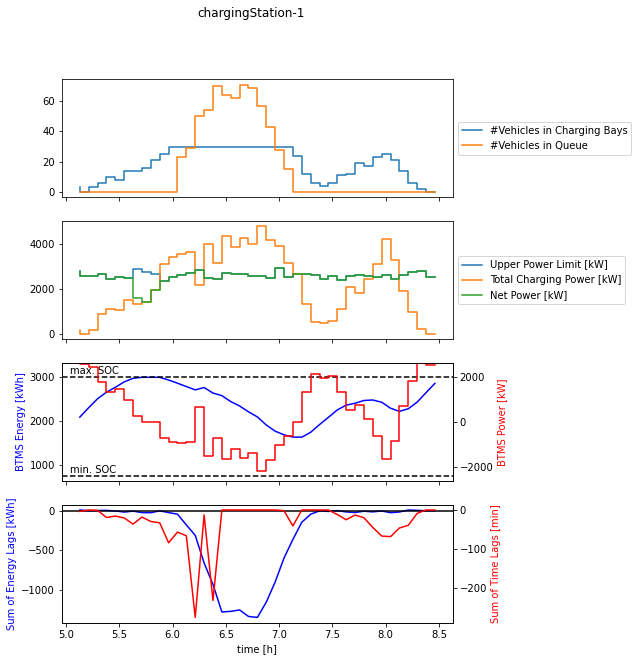

In [19]:
import matplotlib.pyplot as plt
loadDataFromFile = False
plotChargingStation = 0

if loadDataFromFile == True:
    pass
else:
    ChSt = ResultWriter.ChargingStationStates.loc[ResultWriter.ChargingStationStates.ChargingStationID == chargingStations[plotChargingStation].ChargingStationId]

fig, ax = plt.subplots(4,1, sharex=True)
fig.suptitle(chargingStations[plotChargingStation].ChargingStationId)
ax[0].step(ChSt.time/3600, ChSt.BaysNumberOfVehicles, label = "#Vehicles in Charging Bays")
ax[0].step(ChSt.time/3600, ChSt.QueueNumberOfVehicles, label = "#Vehicles in Queue")
ax[0].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
#ax[0].grid()

ax[1].step(ChSt.time/3600, ChSt.GridPowerUpper, label = "Upper Power Limit [kW]")
ax[1].step(ChSt.time/3600, ChSt.TotalChargingPower, label = "Total Charging Power [kW]")
ax[1].step(ChSt.time/3600, ChSt.TotalChargingPower + ChSt.BtmsPower, label = "Net Power [kW]")
#ax[1].step(ChSt.time/3600, ChSt.BtmsPower, label = "Net Power [kW]")
ax[1].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
#ax[1].grid()

ax[2].plot(ChSt.time/3600, ChSt.BtmsEnergy, label = "BTMS Energy [kWh]", color = "blue")
ax[2].set_ylabel("BTMS Energy [kWh]", color = "blue")

y1=chargingStations[plotChargingStation].BtmsSize*chargingStations[plotChargingStation].BtmsMaxSoc
ax[2].axhline(y = y1, linestyle = "--", color ="black")

y2=chargingStations[plotChargingStation].BtmsSize*chargingStations[plotChargingStation].BtmsMinSoc
ax[2].axhline(y = y2, linestyle = "--", color ="black")
#ax[2].grid()

ylim = ax[2].get_ylim()
ax[2].set_ylim([ylim[0], 1.07*ylim[1]])
ylim = ax[2].get_ylim()
print(ylim)
dy = ylim[1]-ylim[0]
xlim = ax[2].get_xlim()
x = xlim[0]
dx = xlim[1]-xlim[0]
ax[2].text(x+0.02*dx, y1+0.03*dy, "max. SOC")
ax[2].text(x+0.02*dx, y2+0.03*dy, "min. SOC")

ax1 = ax[2].twinx()
ax1.step(ChSt.time/3600, ChSt.BtmsPower, label = "BTMS Power [kW]", color = "red")
ax1.set_ylabel("BTMS Power [kW]", color = "red")
ax1.set_ylim([-chargingStations[plotChargingStation].GridPowerMax_Nom, chargingStations[plotChargingStation].GridPowerMax_Nom])


ax[3].plot(ChSt.time/3600, ChSt.EnergyLagSum, label = "Sum of Energy Lags [kWh]", color ="blue")
ax[3].axhline(y = 0, color="black")
ax[3].set_ylabel("Sum of Energy Lags [kWh]", color = "blue")
#ax[3].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))

ax2 = ax[3].twinx()
ax2.plot(ChSt.time/3600, ChSt.TimeLagSum/60, label= "Sum of Time Lags [min]", color = "red")
ax2.set_ylabel("Sum of Time Lags [min]", color ="red")

ax[3].set_xlabel("time [h]")

fig.set_size_inches(7, 10)
